In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, LSTM, CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Bidirectional, InputLayer

from keras import regularizers 
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
tf.set_random_seed(201)
np.random.seed(201)

## 데이터 로드

In [3]:
DATA_IN_PATH = './data_nsmc/word_dict/'
DATA_OUT_PATH = './data_out/'
#INPUT_TRAIN_DATA = 'input.npy'
#LABEL_TRAIN_DATA = 'label.npy'
#DATA_CONFIGS = 'data_configs.json'

INPUT_TRAIN_DATA = 'pos_input.npy'
LABEL_TRAIN_DATA = 'pos_label.npy'
DATA_CONFIGS = 'pos_data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r',  -1, "utf-8"))

In [4]:
TEST_SPLIT = 0.2
RND_SEED = 0
VOCAB_SIZE = prepro_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 512
MAX_LEN = 200
max_features = 20000

In [5]:
train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RND_SEED)

In [6]:
train_input = sequence.pad_sequences(train_input, maxlen=MAX_LEN)
eval_input = sequence.pad_sequences(eval_input, maxlen=MAX_LEN)

## 모델 설정

In [7]:
def Model():
    model = Sequential()
    model.add(Embedding(max_features, EMB_SIZE, input_length=MAX_LEN))    
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          99328     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,667,649
Tr

In [9]:
# 최선의 모델 model 저장
MODEL_PATH = './model/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_full_path = MODEL_PATH + 'best_train_model.hdf5'

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
check_point = ModelCheckpoint(filepath=model_full_path, monitor='val_loss', verbose=1, save_best_only=True)

In [11]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 10, validation_split = 0.2, callbacks=[early_stopping, check_point])


Train on 96000 samples, validate on 24000 samples
Epoch 1/10
96000/96000 [==============================] - 9s 95us/step - loss: 0.4843 - accuracy: 0.7606 - val_loss: 0.3783 - val_accuracy: 0.8305

Epoch 00001: val_loss improved from inf to 0.37829, saving model to ./model/best_train_model.hdf5
Epoch 2/10
96000/96000 [==============================] - 7s 73us/step - loss: 0.3355 - accuracy: 0.8549 - val_loss: 0.3758 - val_accuracy: 0.8317

Epoch 00002: val_loss improved from 0.37829 to 0.37579, saving model to ./model/best_train_model.hdf5
Epoch 3/10
96000/96000 [==============================] - 7s 72us/step - loss: 0.2941 - accuracy: 0.8768 - val_loss: 0.3888 - val_accuracy: 0.8286

Epoch 00003: val_loss did not improve from 0.37579


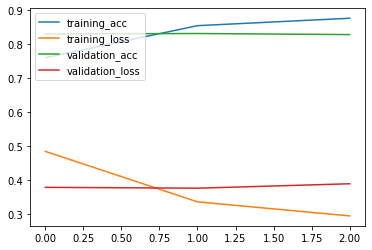

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['training_acc', 'training_loss','validation_acc', 'validation_loss'], loc = 'upper left')
plt.show()

In [13]:
model.load_weights(model_full_path)
results = model.evaluate(eval_input, eval_label)
print('Test accuracy: ', results[1])

30000/30000 [==============================] - 15s 491us/step
Test accuracy:  0.831166684627533


## K-fold validation 사용 

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = label_data[train_index], label_data[test_index]
    
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [15]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          99328     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,667,649
Trainable params: 2,667,649
Non-trainable params: 0
____________________________________________

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')

In [17]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 10)

Epoch 1/10
142500/142500 [==============================] - 10s 70us/step - loss: 0.4373 - accuracy: 0.7925
Epoch 2/10
142500/142500 [==============================] - 10s 67us/step - loss: 0.3281 - accuracy: 0.8579
Epoch 3/10
142500/142500 [==============================] - 10s 67us/step - loss: 0.2905 - accuracy: 0.8743
Epoch 4/10
142500/142500 [==============================] - 10s 70us/step - loss: 0.2547 - accuracy: 0.8918
Epoch 5/10
142500/142500 [==============================] - 10s 69us/step - loss: 0.2161 - accuracy: 0.9096
Epoch 6/10
142500/142500 [==============================] - 10s 67us/step - loss: 0.1840 - accuracy: 0.9238
Epoch 7/10
142500/142500 [==============================] - 10s 67us/step - loss: 0.1562 - accuracy: 0.9358
Epoch 8/10
142500/142500 [==============================] - 10s 69us/step - loss: 0.1332 - accuracy: 0.9457
Epoch 9/10
142500/142500 [==============================] - 10s 67us/step - loss: 0.1149 - accuracy: 0.9531
Epoch 10/10
142500/142500 [=

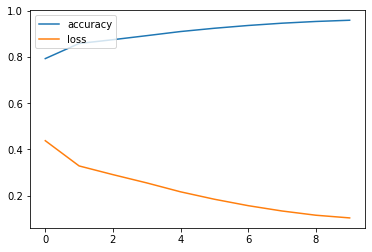

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.show()

In [19]:
score = model.evaluate(X_test,y_test)
print('Test accuracy: ', score[1])

7500/7500 [==============================] - 4s 478us/step
Test accuracy:  0.8102666735649109
